In [2]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
survey_directory = "/Users/kritiaxh/Documents/PoldrackLab/experiment-factory-analysis/out"

surveys = ['ai_survey']

subject_info = pd.read_csv('/Users/kritiaxh/Documents/PoldrackLab/SharedControl/data/participant_tracking.csv')
#Create a mapping between the subject ID and ExpFactory ID
participant_mapping = {
    row['ExpFactory ID'].strip() if isinstance(row['ExpFactory ID'], str) else row['ExpFactory ID']: row['Subject'] 
    for _, row in subject_info.iterrows()
}

In [4]:
def correct_reverse_coding(row):
    """
    Correct the scoring of survey responses, particularly for reverse-coded questions.

    Parameters:
    - row: A pandas Series representing a single row of the DataFrame containing the survey data.

    Returns:
    - The corrected response value. If the response is NaN, returns None. 
      If the question is specifically 'ai_survey_5_options', applies reverse coding; 
      otherwise, returns the integer value of the response.
    """
    if pd.isna(row['response']):
        return None
    elif row['question_key'] == 'ai_survey_5_options':
        return 6 - int(row['response'])
    else:
        return int(row['response'])

In [5]:
survey_results = {}
# Process each subject's surveys
for foldername in os.listdir(survey_directory):
    folder_path = os.path.join(survey_directory, foldername)
    # Check if it is indeed a directory
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith('.csv'):
                # Check if the filename contains any of the specified surveys
                if any(survey in filename for survey in surveys):
                    #expfactory_id = filename.split('_')[0]  # Extract Experiment Factory ID from the filename
                    
                    # Map to subject ID
                    #subject_id = participant_mapping.get(expfactory_id)
                    subject_id = filename.split('_')[0]
                    
                    if subject_id:
                        df = pd.read_csv(os.path.join(folder_path, filename))
                        df['corrected_value'] = df.apply(correct_reverse_coding, axis=1)

                        survey_results[subject_id] = {'data': df, 'average_score': df['corrected_value'].mean(), 'total_score': df['corrected_value'].sum()}

                        # Extract scores for each question under the 'text' column
                        for question in df['text']:
                            survey_results[subject_id][question] = df.loc[df['text'] == question, 'corrected_value'].values[0]
                
# Create a summary DataFrame
result_df = pd.DataFrame({
    'subject_id': survey_results.keys(),
    'average_score': [details['average_score'] for details in survey_results.values()],
    'total_score': [details['total_score'] for details in survey_results.values()]
})

# Loop through each subject to add question scores to the DataFrame
for subject_id, details in survey_results.items():
    df = details['data']
    for question in df['text']:
        result_df.loc[result_df['subject_id'] == subject_id, question] = details[question]

result_df = result_df.sort_values(by='subject_id')

# Output the results
result_df.to_csv('/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/survey_scores.csv', index=False)

Mapping of Question Numbers to Original Questions:
Q1: AI is making our daily lives easier.
Q2: I believe that increased use of artificial intelligence will make the world a safer place.
Q3: I trust a self driving car to drive safer than I would normally.
Q4: I trust artificial intelligence.
Q5: I trust companies that do not use AI over companies that do.
Q6: I would prefer to drive a self-driving car over a regular car.
Q7: More vehicles, software, and appliances should make use of AI.


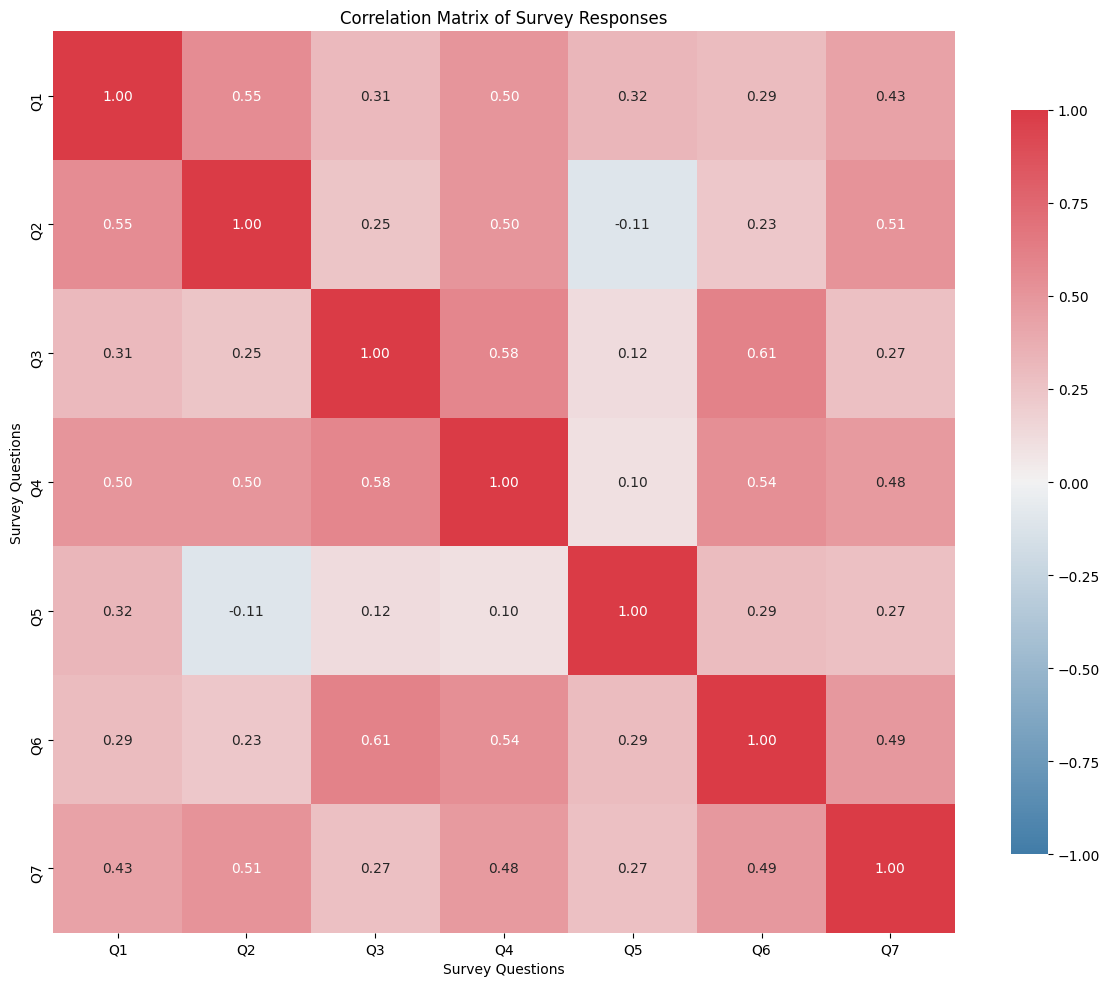

In [6]:
# Note- this matrix only shows the top row values with a newer version of Matplotlib. To run this, do 'pip install matplotlib-3.7.3' 
# and restart the kernel. After you run this, revert to the newer version. 

# Step 1: Extract corrected values into a DataFrame
combined_data = []

for subject_id, details in survey_results.items():
    df = details['data']
    for idx, row in df.iterrows():
        combined_data.append({'subject_id': subject_id, 'text': row['text'], 'corrected_value': row['corrected_value']})

# Step 2: Create a pivot DataFrame
pivot_df = pd.DataFrame(combined_data)
pivot_df = pivot_df.pivot(index='subject_id', columns='text', values='corrected_value')

# Step 3: Create a mapping from question number to original questions
question_mapping = {f'Q{i + 1}': question for i, question in enumerate(pivot_df.columns)}

# Print the mapping of question numbers to original questions
print("Mapping of Question Numbers to Original Questions:")
for q_num, original_question in question_mapping.items():
    print(f"{q_num}: {original_question}")

# Step 4: Rename the columns to Q1, Q2, ..., Q7
new_columns = [f'Q{i + 1}' for i in range(len(pivot_df.columns))]
pivot_df.columns = new_columns

# Step 5: Calculate the correlation matrix
correlation_matrix = pivot_df.corr()

# Step 6: Create a heatmap of the correlation matrix
cmap = sns.diverging_palette(240, 10, as_cmap=True)  # blue to red palette

# Create the figure for the heatmap
plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, center=0, square=True, 
            cbar_kws={"shrink": .8}, vmin=-1, vmax=1, annot_kws={"size": 10}) 

# Set the title and labels
plt.title("Correlation Matrix of Survey Responses")
plt.xlabel("Survey Questions")
plt.ylabel("Survey Questions")

# Update ticks to show new names and adjust positions for in-between boxes
tick_positions = np.arange(len(new_columns)) + 0.5  # Shift ticks to the center of each box
plt.xticks(ticks=tick_positions, labels=new_columns)
plt.yticks(ticks=tick_positions, labels=new_columns)

plt.tight_layout()

# Save the figure
plt.savefig('figures/ai_survey_correlation_matrix.png', dpi=300) 
plt.show()

# Save the correlation matrix to a CSV file
correlation_matrix.to_csv('output/ai_survey_correlation_matrix.csv', index=True)